In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from math import ceil, floor

-95.65117289470271


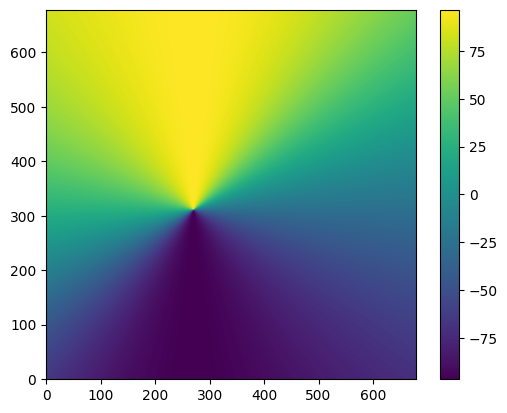

In [3]:
#checking the vaildity of the source plane map
import copy
import matplotlib.pyplot as plt
%matplotlib inline


# import the LensModel class #
from lenstronomy.LensModel.lens_model import LensModel

# specify the choice of lens models #
lens_model_list = ['SIE']

# setup lens model class with the list of lens models #
lensModel = LensModel(lens_model_list=lens_model_list)

# define parameter values of lens models #
kwargs_sie = {'theta_E': 100, 'e1':0, 'e2':0.4, 'center_x': 270, 'center_y': 310}
kwargs_lens = [kwargs_sie]

# image plane coordinate #
size = 678
x_grid, y_grid = np.meshgrid(np.linspace(0, size, size+1), np.linspace(0, size, size+1))
# Flatten the grid for calculations
x_flat = x_grid.flatten()
y_flat = y_grid.flatten()

# Calculate convergence (kappa)
kappa = lensModel.kappa(x_flat, y_flat, kwargs_lens)

# Reshape back to 2D grid
#kappa_2d = kappa.reshape(x_grid.shape)

# ray-tracing to the source plane

alpha_x, alpha_y = lensModel.alpha(x_flat, y_flat, kwargs_lens)
# make beta_x and beta_y 2d

alpha_x_2d = alpha_x.reshape(x_grid.shape) #(y,x)
alpha_y_2d = alpha_y.reshape(x_grid.shape) #(y,x)
plt.imshow(alpha_y_2d)
plt.colorbar()
plt.gca().invert_yaxis()
print(alpha_y_2d[100,300])




[(396, 328), (395, 329), (395, 330), (395, 331), (361, 395), (360, 396), (361, 396), (360, 397), (284, 437), (285, 437), (286, 437)]
[(242, 282), (396, 324), (396, 325), (396, 326), (396, 327), (358, 397), (359, 397), (357, 398), (358, 398), (357, 399), (284, 436), (285, 436), (286, 436), (287, 436)]


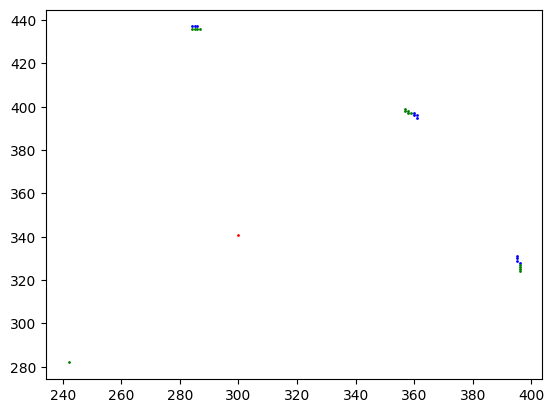

In [4]:
# make a subpixel circle
center = (300, 340.8)
radius = 0.1

# touch 2 pixels case
nbh_ceil = (center[0], ceil(center[1]))
nbh_floor = (center[0], floor(center[1]))

img_int_up = []
img_int_down = []


for i in range(size):
    for j in range(size):
        ycoord = i-alpha_y_2d[i,j] # src coord
        xcoord = j-alpha_x_2d[i,j]
        if ycoord<0 or ycoord>677 or xcoord<0 or xcoord>677:
            continue
        if round(ycoord) == nbh_ceil[1] and round(xcoord) == nbh_ceil[0]:
            img_int_up.append((j,i)) #(x,y)
        if round(ycoord) == nbh_floor[1] and round(xcoord) == nbh_floor[0]:
            img_int_down.append((j,i))
        


plt.scatter(center[0], center[1], c='r', s=1)
plt.scatter([i[0] for i in img_int_up], [i[1] for i in img_int_up], c='b', s=1)
plt.scatter([i[0] for i in img_int_down], [i[1] for i in img_int_down], c='g', s=1)
print(img_int_up)
print(img_int_down)

In [1]:
def src_pos_test(img_guess, lensModel=lensModel):
    alpha_x, alpha_y = lensModel.alpha(img_guess[0], img_guess[1], kwargs_lens)
    return (img_guess[0]-alpha_x, img_guess[1]-alpha_y)
int_guess = (300, 340.8)
diff = np.sqrt((src_pos_test(int_guess)[0]-center[0])**2 + (src_pos_test(int_guess)[1]-center[1])**2)

NameError: name 'lensModel' is not defined

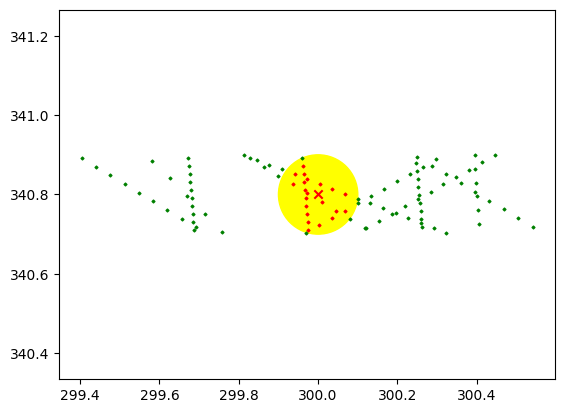

In [100]:
# Number of steps for interpolation
num_steps = 50
n=0
# Function to interpolate between two points

# Function to interpolate deflection angles
def interpolate_deflection(p1, p2, num_steps, alpha_y_2d):
    deflection_steps = []
    for t in range(num_steps + 1):
        ratio = t / num_steps
        y = p1[1] + (p2[1] - p1[1]) * ratio
        x = p1[0] + (p2[0] - p1[0]) * ratio
        alpha_x = alpha_x_2d[p1[1],p1[0]]*ratio + alpha_x_2d[p2[1],p2[0]]*(1-ratio)
        alpha_y = alpha_y_2d[p1[1],p1[0]]*ratio + alpha_y_2d[p2[1],p2[0]]*(1-ratio)
        src_y = y-alpha_y
        src_x = x-alpha_x
        deflection_steps.append([x, y, src_x, src_y])
    return deflection_steps

points = []

# Generate steps for each pair of points
for i in range(len(img_int_up)):
    for j in range(len(img_int_down)):
        up = img_int_up[i]
        down = img_int_down[j]
        if abs(up[0]-down[0])>1 or abs(up[1]-down[1])>1:
            continue
        if up[0] == down[0] and up[1] == down[1]:
            continue
        # Get img pos and src y coord 
        src_pos = interpolate_deflection(up, down, num_steps, alpha_y_2d)
    
        for k in range(len(src_pos)):
            dy = abs(src_pos[k][3] - center[1])
            if dy<radius:
                points.append(src_pos[k])

from matplotlib.patches import Circle
circle = Circle(center, radius, color='yellow', fill=True)
ax = plt.gca()  # Get current axes
ax.add_patch(circle)  # Add the circle to the plot
plt.scatter(center[0], center[1], c='r', marker='x')
plt.axis('equal')  # Set equal scaling by changing axis limits

for i in range(len(points)):
    dist = np.sqrt((points[i][2]-center[0])**2 + (points[i][3]-center[1])**2)
    if dist < radius:
        plt.scatter(points[i][2], points[i][3], c='r', s=2, marker='D')
    else:
        plt.scatter(points[i][2], points[i][3], c='g', s=2, marker='D')

Interpolation algo trials

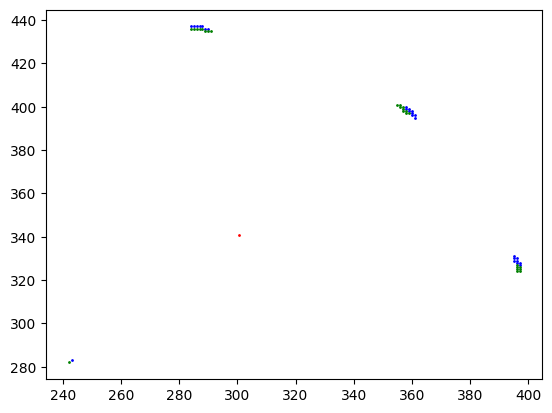

In [89]:
# trying 2d interpolation

# make a subpixel circle
center = (300.45, 340.8)
radius = 0.1

# locate the source plane pixel that the center of the circle is in
nbh_ceil_r = (ceil(center[0]), ceil(center[1]))
nbh_ceil_l = (floor(center[0]), ceil(center[1]))
nbh_floor_r = (ceil(center[0]), floor(center[1]))
nbh_floor_l = (floor(center[0]), floor(center[1]))
img_int_up_r = []
img_int_up_l = []
img_int_down_r = []
img_int_down_l = []

for i in range(size):
    for j in range(size):
        ycoord = i-alpha_y_2d[i,j] # src coord
        xcoord = j-alpha_x_2d[i,j]
        if ycoord<0 or ycoord>677 or xcoord<0 or xcoord>677:
            continue
        if round(ycoord) == nbh_ceil_r[1] and round(xcoord) == nbh_ceil_r[0]:
            img_int_up_r.append((j,i)) #(x,y)
        if round(ycoord) == nbh_ceil_l[1] and round(xcoord) == nbh_ceil_l[0]:
            img_int_up_l.append((j,i))
        if round(ycoord) == nbh_floor_r[1] and round(xcoord) == nbh_floor_r[0]:
            img_int_down_r.append((j,i))
        if round(ycoord) == nbh_floor_l[1] and round(xcoord) == nbh_floor_l[0]:
            img_int_down_l.append((j,i)) #(x,y)


plt.scatter(center[0], center[1], c='r', s=1)
plt.scatter([i[0] for i in img_int_up_r], [i[1] for i in img_int_up_r], c='b', s=1)
plt.scatter([i[0] for i in img_int_up_l], [i[1] for i in img_int_up_l], c='b', s=1)
plt.scatter([i[0] for i in img_int_down_r], [i[1] for i in img_int_down_r], c='g', s=1)
plt.scatter([i[0] for i in img_int_down_l], [i[1] for i in img_int_down_l], c='g', s=1)


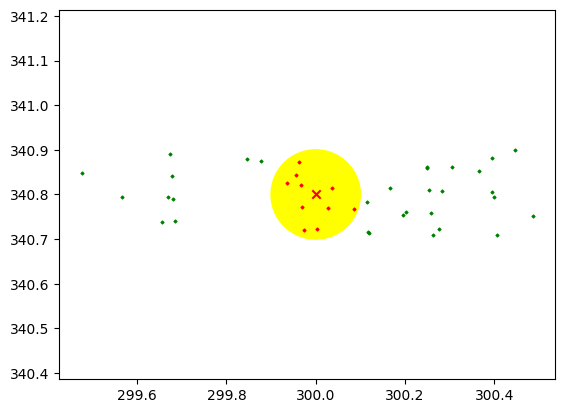

In [105]:

# Number of steps for interpolation
num_steps = 20
n=0
# Function to interpolate between two points

# Function to interpolate deflection angles
def interpolate_deflection(p1, p2, num_steps, alpha_y_2d):
    deflection_steps = []
    for t in range(num_steps + 1):
        ratio = t / num_steps
        y = p1[1] + (p2[1] - p1[1]) * ratio
        x = p1[0] + (p2[0] - p1[0]) * ratio
        alpha_x = alpha_x_2d[p1[1],p1[0]]*ratio + alpha_x_2d[p2[1],p2[0]]*(1-ratio)
        alpha_y = alpha_y_2d[p1[1],p1[0]]*ratio + alpha_y_2d[p2[1],p2[0]]*(1-ratio)
        src_y = y-alpha_y
        src_x = x-alpha_x
        deflection_steps.append([x, y, src_x, src_y])
    return deflection_steps

points = []

# Generate steps for each pair of points
for i in range(len(img_int_up)):
    for j in range(len(img_int_down)):
       
        up = img_int_up[i]
        down = img_int_down[j]
        if abs(up[0]-down[0])>1 or abs(up[1]-down[1])>1:
            continue
        if up[0] == down[0] and up[1] == down[1]:
            continue
        # Get img pos and src y coord 
        src_pos = interpolate_deflection(up, down, num_steps, alpha_y_2d)
    
        for k in range(len(src_pos)):
            dy = abs(src_pos[k][3] - center[1])
            if dy<radius:
                points.append(src_pos[k])

from matplotlib.patches import Circle
circle = Circle(center, radius, color='yellow', fill=True)
ax = plt.gca()  # Get current axes
ax.add_patch(circle)  # Add the circle to the plot
plt.scatter(center[0], center[1], c='r', marker='x')
plt.axis('equal')  # Set equal scaling by changing axis limits

for i in range(len(points)):
    dist = np.sqrt((points[i][2]-center[0])**2 + (points[i][3]-center[1])**2)
    if dist < radius:
        plt.scatter(points[i][2], points[i][3], c='r', s=2, marker='D')
    else:
        plt.scatter(points[i][2], points[i][3], c='g', s=2, marker='D')
    
            
